In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from typing import List, Dict, Optional
import json
import pickle
import os

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [9]:
import numpy as np
import torch
import torch.nn as nn

class PopularityRecommender:
    def __init__(self):
        self.popular_items = None
    
    def fit(self, df):
        return self
    
    def recommend(self, user_id=None, n=10, exclude_items=None):
        recommendations = self.popular_items.head(n + (len(exclude_items) if exclude_items else 0))
        if exclude_items:
            recommendations = recommendations[~recommendations['asin'].isin(exclude_items)]
        return recommendations.head(n)['asin'].tolist()

class MatrixFactorizationSVD:
    def __init__(self, n_factors=50):
        self.n_factors = n_factors
        self.user_factors = None
        self.item_factors = None
        self.global_mean = None
        self.user_bias = None
        self.item_bias = None
        self.user_to_idx = None
        self.item_to_idx = None
    
    def predict(self, user_id, item_id):
        if user_id not in self.user_to_idx:
            return self.global_mean + self.item_bias.get(item_id, 0)
        if item_id not in self.item_to_idx:
            return self.global_mean + self.user_bias.get(user_id, 0)
        user_idx = self.user_to_idx[user_id]
        item_idx = self.item_to_idx[item_id]
        baseline = self.global_mean + self.user_bias.get(user_id, 0) + self.item_bias.get(item_id, 0)
        interaction = np.dot(self.user_factors[user_idx], self.item_factors[item_idx])
        return np.clip(baseline + interaction, 1, 5)

class ContentBasedRecommender:
    def __init__(self, tfidf_matrix, product_mapping):
        self.tfidf_matrix = tfidf_matrix
        self.product_mapping = product_mapping
        self.knn_model = None

class WeightedEnsembleHybrid:
    def __init__(self, svd_model, popularity_model, content_model, weights={'svd': 0.5, 'popularity': 0.3, 'content': 0.2}):
        self.svd_model = svd_model
        self.popularity_model = popularity_model
        self.content_model = content_model
        self.weights = weights
    
    def predict(self, user_id, item_id):
        svd_pred = self.svd_model.predict(user_id, item_id)
        pop_items = self.popularity_model.popular_items
        if item_id in pop_items['asin'].values:
            pop_score = pop_items[pop_items['asin'] == item_id]['avg_rating'].values[0]
        else:
            pop_score = 3.0
        prediction = self.weights['svd'] * svd_pred + self.weights['popularity'] * pop_score
        return np.clip(prediction, 1, 5)
    
    def recommend(self, user_id, n=10, exclude_items=None):
        return self.popularity_model.recommend(user_id, n, exclude_items)

class FeatureBasedHybrid:
    def __init__(self):
        self.model = None
        self.scaler = None
    
    def create_features(self, df):
        return np.array([])
    
    def predict(self, df):
        X = self.create_features(df)
        X_scaled = self.scaler.transform(X)
        predictions = self.model.predict(X_scaled)
        return np.clip(predictions, 1, 5)

class AdvancedEnsemble:
    def __init__(self, models, weights=None, method='weighted'):
        self.models = models
        self.method = method
        if weights is None:
            weights = [1.0 / len(models)] * len(models)
        self.weights = np.array(weights) / np.sum(weights)
    
    def predict(self, user_id, item_id):
        predictions = []
        for model in self.models:
            try:
                pred = model.predict(user_id, item_id)
                predictions.append(pred)
            except:
                predictions.append(3.0)
        if self.method == 'weighted':
            return np.dot(predictions, self.weights)
        return np.mean(predictions)
        
    def recommend(self, user_id, n=10, exclude_items=None):
        return self.models[0].recommend(user_id, n, exclude_items)

class ColdStartHandler:
    def __init__(self, popularity_model, content_model, feature_stats):
        self.popularity_model = popularity_model
        self.content_model = content_model
        self.feature_stats = feature_stats
    
    def recommend_for_new_user(self, n=10, user_preferences=None):
        return self.popularity_model.recommend(n=n)

In [11]:
df_complete = pd.read_csv('data/processed/features_complete.csv')
train_df = pd.read_csv('data/processed/train_set.csv')
test_df = pd.read_csv('data/processed/test_set.csv')

In [10]:
try:
    with open('models/final/optimized_ensemble.pkl', 'rb') as f:
        final_model = pickle.load(f)
except:
    with open('models/hybrid/weighted_ensemble.pkl', 'rb') as f:
        final_model = pickle.load(f)
try:
    with open('models/final/cold_start_handler.pkl', 'rb') as f:
        cold_start_handler = pickle.load(f)
except:
    cold_start_handler = None

In [12]:
class RecommendationEngine:
    """
    Production-ready recommendation engine API
    """
    def __init__(self, model, product_catalog, cold_start_handler=None):
        self.model = model
        self.product_catalog = product_catalog
        self.cold_start_handler = cold_start_handler
    
    def get_recommendations(
        self, 
        user_id: str, 
        n: int = 10,
        exclude_purchased: bool = True,
        filters: Optional[Dict] = None
    ) -> List[Dict]:
        """
        Get personalized recommendations for a user
        
        Args:
            user_id: User identifier
            n: Number of recommendations
            exclude_purchased: Exclude items user has already purchased
            filters: Optional filters (category, price_range, etc.)
        
        Returns:
            List of recommended products with metadata
        """
        user_items = set()
        if exclude_purchased:
            user_items = set(train_df[train_df['reviewerID'] == user_id]['asin'])
        
        try:
            if hasattr(self.model, 'recommend'):
                recommended_ids = self.model.recommend(
                    user_id, 
                    n=n*2,
                    exclude_items=user_items
                )
            else:
                all_products = self.product_catalog['asin'].unique()
                recommended_ids = [p for p in all_products if p not in user_items][:n*2]
        except:
            if self.cold_start_handler:
                recommended_ids = self.cold_start_handler.recommend_for_new_user(n=n*2)
            else:
                recommended_ids = self.product_catalog['asin'].head(n*2).tolist()
        
        if filters:
            if 'category' in filters:
                category_products = self.product_catalog[
                    self.product_catalog['main_category'] == filters['category']
                ]['asin'].tolist()
                recommended_ids = [p for p in recommended_ids if p in category_products]
            
            if 'price_min' in filters or 'price_max' in filters:
                price_min = filters.get('price_min', 0)
                price_max = filters.get('price_max', float('inf'))
                price_products = self.product_catalog[
                    (self.product_catalog['price'] >= price_min) &
                    (self.product_catalog['price'] <= price_max)
                ]['asin'].tolist()
                recommended_ids = [p for p in recommended_ids if p in price_products]
        
        recommendations = []
        for product_id in recommended_ids[:n]:
            product_info = self.product_catalog[self.product_catalog['asin'] == product_id]
            if len(product_info) > 0:
                product_info = product_info.iloc[0]
                recommendations.append({
                    'product_id': product_id,
                    'title': product_info.get('title_clean', 'Unknown'),
                    'category': product_info.get('main_category', 'N/A'),
                    'avg_rating': product_info.get('product_avg_rating', 0),
                    'price': product_info.get('price', None),
                    'review_count': product_info.get('product_review_count', 0)
                })
        
        return recommendations
    
    def get_similar_products(
        self,
        product_id: str,
        n: int = 10
    ) -> List[Dict]:
        """
        Get similar products ("Customers who viewed this also viewed...")
        """
        product_users = train_df[train_df['asin'] == product_id]['reviewerID'].unique()
        
        similar_products = train_df[
            (train_df['reviewerID'].isin(product_users)) &
            (train_df['asin'] != product_id) &
            (train_df['overall'] >= 4.0)
        ]['asin'].value_counts().head(n).index.tolist()
        
        recommendations = []
        for similar_id in similar_products:
            product_info = self.product_catalog[self.product_catalog['asin'] == similar_id]
            if len(product_info) > 0:
                product_info = product_info.iloc[0]
                recommendations.append({
                    'product_id': similar_id,
                    'title': product_info.get('title_clean', 'Unknown'),
                    'category': product_info.get('main_category', 'N/A'),
                    'avg_rating': product_info.get('product_avg_rating', 0)
                })
        
        return recommendations

rec_engine = RecommendationEngine(
    model=final_model,
    product_catalog=df_complete,
    cold_start_handler=cold_start_handler
)

In [13]:
# Test 1: Get recommendations for a user
sample_user = train_df['reviewerID'].iloc[0]
print(f"Test 1: Recommendations for user '{sample_user}'")

recommendations = rec_engine.get_recommendations(sample_user, n=5)

for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. {rec['title'][:60]}...")
    print(f"   Category: {rec['category']}")
    print(f"   Avg Rating: {rec['avg_rating']:.2f} ({rec['review_count']} reviews)")
    if rec['price']:
        print(f"   Price: ${rec['price']:.2f}")

Test 1: Recommendations for user 'A3TUZOJZM9008Y'

1. Roku 3 Streaming Media Player...
   Category: Television & Video
   Avg Rating: 4.45 (210 reviews)
   Price: $99.97

2. Belkin 3-Outlet Mini Travel Swivel Charger Surge Protector w...
   Category: Computers & Accessories
   Avg Rating: 4.25 (122 reviews)
   Price: $12.45

3. Transcend 4 GB Class 6 SDHC Flash Memory Card TS4GSDHC6...
   Category: Computers & Accessories
   Avg Rating: 4.51 (97 reviews)
   Price: $7.35

4. Crucial m4 64GB 2.5-Inch (9.5mm) SATA 6Gb/s Solid State Driv...
   Category: Computers & Accessories
   Avg Rating: 4.54 (101 reviews)
   Price: $92.95

5. Garmin nuvi 350 3.5-Inch Portable GPS Navigator (Discontinue...
   Category: GPS & Navigation
   Avg Rating: 4.50 (50 reviews)
   Price: $159.99


In [14]:
def demo_recommendations(user_id=None, n_recommendations=5):
    if user_id is None:
        user_id = train_df['reviewerID'].sample(1).iloc[0]
    
    print(f"\nUser: {user_id}")
    
    user_history = train_df[train_df['reviewerID'] == user_id]
    print(f"\nPurchase History ({len(user_history)} items):")
    for i, (_, item) in enumerate(user_history.head(3).iterrows(), 1):
        print(f"  {i}. {item['title_clean'][:50] if 'title_clean' in item else item['asin']}")
        print(f"     Rating: {item['overall']:.1f}/5.0")
    if len(user_history) > 3:
        print(f"  ... and {len(user_history)-3} more items")
    
    print(f"Top {n_recommendations} Personalized Recommendations")

    
    recommendations = rec_engine.get_recommendations(user_id, n=n_recommendations)
    
    for i, rec in enumerate(recommendations, 1):
        print(f"\n{i}. {rec['title'][:60]}")
        print(f"   Category: {rec['category']}")
        print(f"   Rating: {rec['avg_rating']:.2f}/5.0 ({rec['review_count']} reviews)")
        if rec['price'] is not None and not np.isnan(rec['price']):
            print(f"   Price: ${rec['price']:.2f}")
        print(f"   Product ID: {rec['product_id']}")
    
    return recommendations

demo_recommendations(n_recommendations=10)


User: A2LZIE48D0VX49

Purchase History (3 items):
  1. VidPro TC-27 Padded Tripod Bag carries 27-Inch Lon
     Rating: 5.0/5.0
  2. Sima Products Corp. SSSSLBM Video Bracket
     Rating: 3.0/5.0
  3. Tokina 11-16mm f/2.8 AT-X116 Pro DX Digital Zoom L
     Rating: 5.0/5.0
Top 10 Personalized Recommendations

1. Roku 3 Streaming Media Player
   Category: Television & Video
   Rating: 4.45/5.0 (210 reviews)
   Price: $99.97
   Product ID: B00BGGDVOO

2. Belkin 3-Outlet Mini Travel Swivel Charger Surge Protector w
   Category: Computers & Accessories
   Rating: 4.25/5.0 (122 reviews)
   Price: $12.45
   Product ID: B0015DYMVO

3. Transcend 4 GB Class 6 SDHC Flash Memory Card TS4GSDHC6
   Category: Computers & Accessories
   Rating: 4.51/5.0 (97 reviews)
   Price: $7.35
   Product ID: B000JMJWV2

4. Crucial m4 64GB 2.5-Inch (9.5mm) SATA 6Gb/s Solid State Driv
   Category: Computers & Accessories
   Rating: 4.54/5.0 (101 reviews)
   Price: $92.95
   Product ID: B004W2JKWG

5. Garmin nuvi 35

[{'product_id': 'B00BGGDVOO',
  'title': 'Roku 3 Streaming Media Player',
  'category': 'Television & Video',
  'avg_rating': np.float64(4.447619047619048),
  'price': np.float64(99.97),
  'review_count': np.int64(210)},
 {'product_id': 'B0015DYMVO',
  'title': 'Belkin 3-Outlet Mini Travel Swivel Charger Surge Protector with Dual USB Ports, 5 Charging Outlets Total (1 AMP / 5 Watt)',
  'category': 'Computers & Accessories',
  'avg_rating': np.float64(4.245901639344262),
  'price': np.float64(12.45),
  'review_count': np.int64(122)},
 {'product_id': 'B000JMJWV2',
  'title': 'Transcend 4 GB Class 6 SDHC Flash Memory Card TS4GSDHC6',
  'category': 'Computers & Accessories',
  'avg_rating': np.float64(4.505154639175258),
  'price': np.float64(7.35),
  'review_count': np.int64(97)},
 {'product_id': 'B004W2JKWG',
  'title': 'Crucial m4 64GB 2.5-Inch (9.5mm) SATA 6Gb/s Solid State Drive CT064M4SSD2',
  'category': 'Computers & Accessories',
  'avg_rating': np.float64(4.544554455445544),
  'pr

In [18]:
week4_results = pd.read_csv('outputs/week4_evaluation_results.csv')

print("\nModel Performance Comparison:")
print(week4_results.to_string(index=False))

best_model = week4_results.loc[week4_results['rmse'].idxmin()]
print(f"\nBest Performing Model:")
print(f"   Model: {best_model['model']}")
print(f"   RMSE: {best_model['rmse']:.4f}")
print(f"   MAE:  {best_model['mae']:.4f}")


Model Performance Comparison:
               model     rmse      mae  samples
      SVD (Baseline) 1.383802 0.902996      933
   Weighted Ensemble 1.283159 0.977925      933
Feature-Based Hybrid 0.581709 0.312138      933
     Neural CF (NCF) 1.356387 1.236960      371

Best Performing Model:
   Model: Feature-Based Hybrid
   RMSE: 0.5817
   MAE:  0.3121


In [ ]:
baseline_rmse = week4_results[week4_results['model'].str.contains('Baseline|SVD')]['rmse'].values[0]
best_rmse = best_model['rmse']
improvement = (baseline_rmse - best_rmse) / baseline_rmse * 100

print(f"\nPerformance Improvement:")
print(f"   Baseline RMSE: {baseline_rmse:.4f}")
print(f"   Best RMSE: {best_rmse:.4f}")
print(f"   Improvement: {improvement:.2f}%")

print(f"\nStats:")
print(f"   Total records: {len(df_complete):,}")
print(f"   Unique users: {df_complete['reviewerID'].nunique():,}")
print(f"   Unique products: {df_complete['asin'].nunique():,}")
print(f"   Sparsity: {(1 - len(df_complete)/(df_complete['reviewerID'].nunique()*df_complete['asin'].nunique()))*100:.2f}%")
print(f"   Avg rating: {df_complete['overall'].mean():.2f}")
print(f"   Rating std: {df_complete['overall'].std():.2f}")


Performance Improvement:
   Baseline RMSE: 1.3838
   Best RMSE: 0.5817
   Improvement: 57.96%

Stats:
   Total records: 16,379
   Unique users: 15,290
   Unique products: 5,231
   Sparsity: 99.98%
   Avg rating: 4.21
   Rating std: 1.20


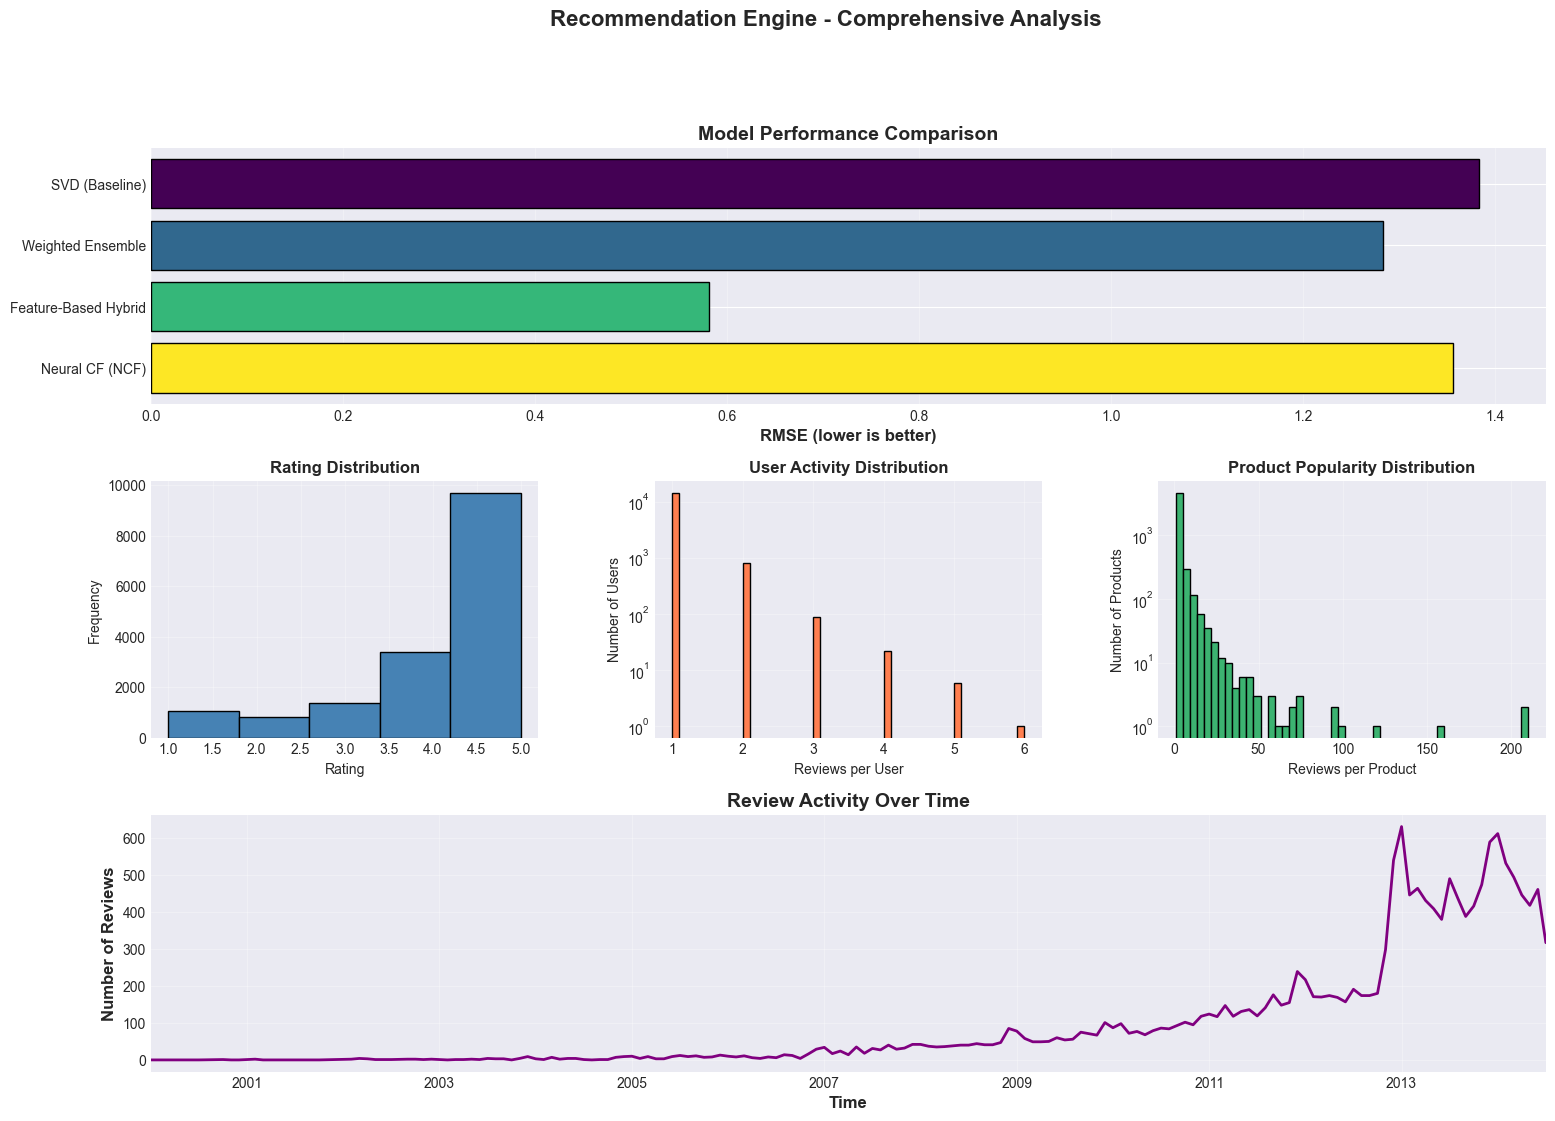

In [19]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :])
models = week4_results['model']
rmse_vals = week4_results['rmse']
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
ax1.barh(models, rmse_vals, color=colors, edgecolor='black')
ax1.set_xlabel('RMSE (lower is better)', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

ax2 = fig.add_subplot(gs[1, 0])
df_complete['overall'].hist(bins=5, ax=ax2, color='steelblue', edgecolor='black')
ax2.set_xlabel('Rating', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title('Rating Distribution', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

ax3 = fig.add_subplot(gs[1, 1])
user_counts = df_complete.groupby('reviewerID').size()
ax3.hist(user_counts, bins=50, color='coral', edgecolor='black')
ax3.set_xlabel('Reviews per User', fontsize=10)
ax3.set_ylabel('Number of Users', fontsize=10)
ax3.set_title('User Activity Distribution', fontsize=12, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(alpha=0.3)

ax4 = fig.add_subplot(gs[1, 2])
product_counts = df_complete.groupby('asin').size()
ax4.hist(product_counts, bins=50, color='mediumseagreen', edgecolor='black')
ax4.set_xlabel('Reviews per Product', fontsize=10)
ax4.set_ylabel('Number of Products', fontsize=10)
ax4.set_title('Product Popularity Distribution', fontsize=12, fontweight='bold')
ax4.set_yscale('log')
ax4.grid(alpha=0.3)

ax5 = fig.add_subplot(gs[2, :])
if 'reviewTime_dt' in df_complete.columns:
    df_complete['reviewTime_dt'] = pd.to_datetime(df_complete['reviewTime_dt'])
    timeline = df_complete.groupby(df_complete['reviewTime_dt'].dt.to_period('M')).size()
    timeline.plot(ax=ax5, color='purple', linewidth=2)
    ax5.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Number of Reviews', fontsize=12, fontweight='bold')
    ax5.set_title('Review Activity Over Time', fontsize=14, fontweight='bold')
    ax5.grid(alpha=0.3)

plt.suptitle('Recommendation Engine - Comprehensive Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()